In [2]:

import mne
from mne.preprocessing import ICA

import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
import eelbrain as eel

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert

from collections import Counter

import sys
sys.path.append('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *

import pickle
import os

In [3]:
eeg_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed_15Hz'
mTRF_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/trained_models'
sv_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv'


In [137]:

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects
#subjects_to_process = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12']
#subjects_to_process = ['05', '08', '17']

n_subs = len(subjects_to_process)
print('processing subjects:', subjects_to_process)

periods = ['post']
#features = 'AM' #AM or onsets

overwrite = False
n_segments = 8
fs = 128
tmin, tmax = -0.5, 0.5 # range of time lag
#regularization = 1
regularizations= [0.0001, 0.01, 1, 100, 10000, 1000000]


processing subjects: ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


## Forward model

In [159]:
r_data = []
sv_to_test = ['firsts', 'firsts_sur', 'onsets_sur', 'fo_sur']
#sv_to_test = ['firsts', 'onsets_sur']
regularization = 1e9


for subject in subjects_to_process:
    for period in periods:
        sub_data = {
            'subject': subject,
            'period': period
        }


        eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat')

        data = loadmat(eeg_path)
        eeg = data['trial_data'].T

        #load support vectors
        sv_data = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))
        sv_o = sv_data['onsets'][0] #take 0 index because it's shaped (1, n_timepoints)
        #np.random.shuffle(onsets_sv) #test if the shuffled data indeed yields chance results


        #segment stimuli and response
        eeg_segments = segment(eeg, n_segments)
        eeg_segments_norm = normalize_responses(eeg_segments) #normalize eeg data
       # print(eeg.shape)
        
        #training TRF model on onsets
        if sv_o.shape[0] > eeg.shape[0]:
            sv_o = sv_o[:eeg.shape[0]]

        onset_segments = segment(sv_o, n_segments) 
        print(onset_segments[0].shape)
 

        fwd_trf_o = TRF(direction=1)
        # _, lambdas = nested_crossval(fwd_trf_o, onset_segments, eeg_segments_norm, fs, tmin, tmax, regularizations)
        # best_lambda = Counter(lambdas).most_common(1)[0][0]

        r_fwd_o = crossval(fwd_trf_o, onset_segments, eeg_segments, fs, tmin, tmax, regularization = regularization)
        sub_data['onsets_raw'] = r_fwd_o
        print(onset_segments[0].shape)
        for sv_type in sv_to_test:
            print(sv_type)
            sv_f = sv_data[sv_type][0]
            

            
            
        #crop support vector if EEG is shorter (sv is always 10 mins long but subs 01 and 04 have shorter recordings)
            
            if sv_f.shape[0] > eeg.shape[0]:
                sv_f = sv_f[:eeg.shape[0]]

            firsts_segments = segment(sv_f, n_segments)
            onset_segments = segment(sv_o, n_segments) 

            
            comb_segments = []
            for i in range(n_segments):
                comb_i = np.vstack([onset_segments[i], firsts_segments[i]]).T
                comb_segments.append(comb_i)
            
            

        #training TRF model on firsts
            fwd_trf_f = TRF(direction=1)
        # #    _, lambdas = nested_crossval(fwd_trf_f, firsts_segments, eeg_segments_norm, fs, tmin, tmax, regularizations)
        #     _, lambdas = nested_crossval(fwd_trf_f, comb_segments, eeg_segments_norm, fs, tmin, tmax, regularizations)
        #     best_lambda = Counter(lambdas).most_common(1)[0][0]

            #r_fwd_f = crossval(fwd_trf_f, firsts_segments, eeg_segments, fs, tmin, tmax, regularization = best_lambda)
            r_fwd_f = crossval(fwd_trf_f, comb_segments, eeg_segments, fs, tmin, tmax, regularization = regularization)

            sub_data[sv_type+'_raw'] = r_fwd_f

        #fwd_trf.train(onset_segments, eeg_segments, fs, tmin, tmax, regularization = 1000)
    r_data.append(sub_data)  

r_df = pd.DataFrame(r_data)   

(9600,)
Cross-validating[##################################################] 8/8

(9600, 1)
firsts
Cross-validating[##################################################] 8/8

firsts_sur
Cross-validating[##################################################] 8/8

onsets_sur
Cross-validating[##################################################] 8/8

fo_sur


KeyboardInterrupt: 

In [158]:
r_df['firsts_diff'] = r_df['firsts_raw'] - r_df['onsets_raw']
r_df['fo_sur_diff'] = r_df['fo_sur_raw'] - r_df['onsets_raw']
r_df

,subject,period,onsets_raw,firsts_raw,firsts_sur_raw,onsets_sur_raw,fo_sur_raw,firsts_diff,fo_sur_diff
0,01,post,0.127244,0.125573,0.127147,0.122869,0.127148,-0.001671,-0.000096
1,04,post,0.041959,0.042517,0.041973,0.042980,0.041974,0.000558,0.000015
2,05,post,0.084939,0.085454,0.085052,0.083330,0.085025,0.000515,0.000086
3,06,post,0.071799,0.071104,0.071708,0.070605,0.071726,-0.000695,-0.000074
4,07,post,0.112452,0.111946,0.112490,0.110103,0.112502,-0.000506,0.000050
5,08,post,0.158709,0.157886,0.158704,0.157710,0.158719,-0.000823,0.000009
6,09,post,0.127203,0.127789,0.127297,0.126909,0.127299,0.000586,0.000096
7,10,post,0.051017,0.051274,0.051039,0.050562,0.051067,0.000257,0.000050
8,11,post,0.053748,0.054493,0.053834,0.053355,0.053807,0.000745,0.000059
9,12,post,0.080383,0.079416,0.080236,0.078142,0.080238,-0.000967,-0.000144


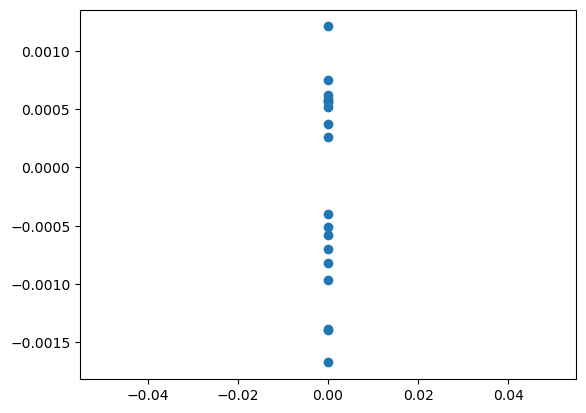

In [147]:
plt.scatter(np.zeros_like(r_df['firsts_diff']), r_df['firsts_diff'])

In [72]:
fwd_trf_f.train(comb_segments, eeg_segments, fs, tmin, tmax, regularization = 1)

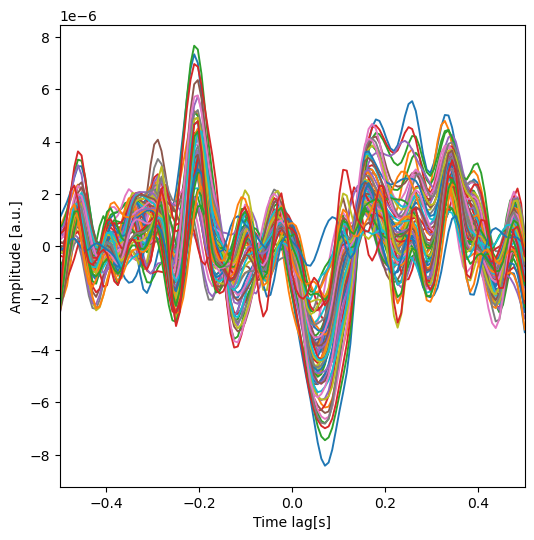

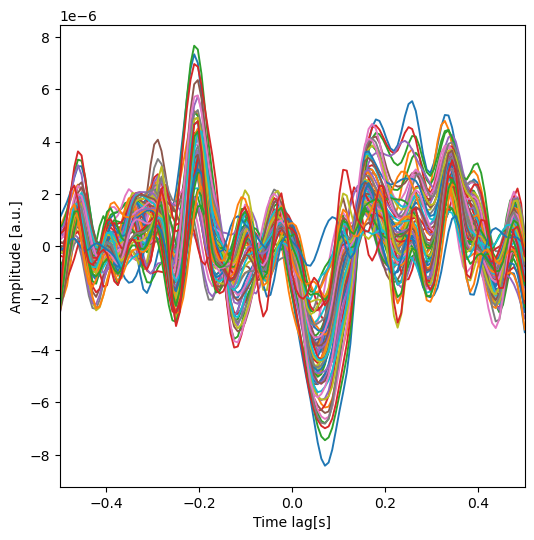

In [78]:
fwd_trf_f.plot(feature = 1)

In [70]:
r_fwd_o

0.159016793310999

In [68]:
r_df

,subject,period,firsts_raw,firsts_sur_raw,onsets_sur_raw,fo_sur_raw
0,08,post,0.011985,0.012671,0.012808,0.012674


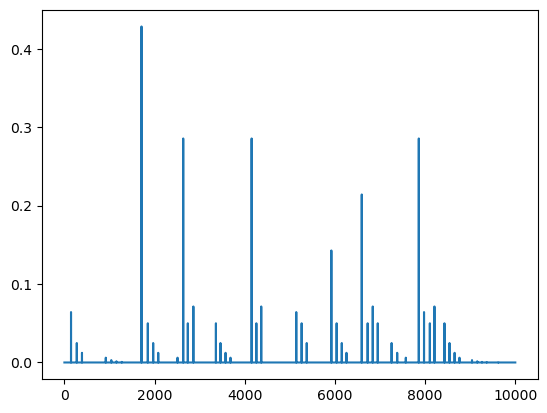

In [38]:
plt.plot(sv_f[0:10000])

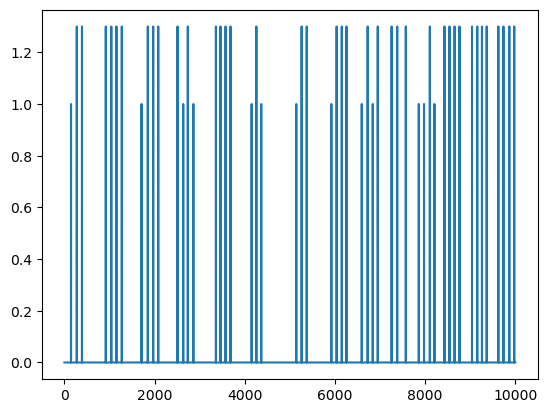

In [32]:
plt.plot(sv_f[0:10000])